# Sprint  09 Tasca 02 : Aprenentatge Supervisat - Regressions

### Objectives
- Models de regressió
- Àrbres de regressió
- Random Forest
- Xarxes Neuronals
- Altres models


### Sources
- https://medium.com/search?q=Mohtadi+Ben+Fraj+in+depth

- https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr



## Exercici 1

Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

### Imports

In [1]:
# Yolo
import warnings
warnings.filterwarnings('ignore')

# Scientific and Data Manipulation Libraries :
import scipy
import numpy as np
import math
from random import sample

# Visualization Libraries :
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb 
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# ML Libraries :
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Retrieve stored dataframe from previous exercise (S09_T01)
%store -r robust_df


### Abstract 

Since we keep using the same data from the previous exercices, in order to keep clarity and awarenes of the whole data processing done before, some tables below are facilitated.

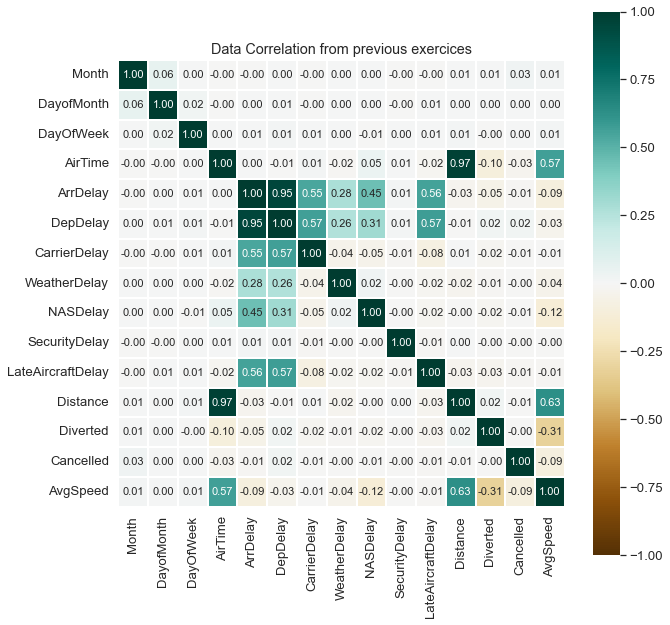

In [2]:
# Check correlation between variables
data_corr = robust_df.corr()

# set style and plot:
sb.set(font_scale=1.2) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(data = data_corr, 
               square = True,
               annot = True,
               cmap = 'BrBG',
               vmin = -1,
               vmax = 1,
               center = 0, 
               linewidths=2,
               ax=ax, 
               annot_kws={"size":11}, fmt='.2f')
            
ax.set(title='Data Correlation from previous exercices')
plt.show()
plt.close()

>Based on the latter exercice (S09_T01), **since AvgSpeed was an  
instrumental variable** bootstrapped to discern realistic values, within 
Distance and AirTime, it doesn't show a strong correlation 
with any of the other variables **and contains some infinite values.I assume it's safe to drop it along with categorical features** since the latter didn't showed any particular insights besides the normally-distributed logic of more flights = more delays 

In [3]:
robust_df.drop(['AvgSpeed','Distance', 'Month', 'DayofMonth', 'DayOfWeek'], axis=1, inplace=True)

robust_df.describe()

,AirTime,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Diverted,Cancelled
count,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06
mean,2.255721e-01,3.914724e-01,4.678182e-01,1.235321e+00,2.383129e+00,1.611419e+00,5.806584e-02,9.052018e-01,4.004541e-03,3.269118e-04
std,8.716506e-01,1.232946e+00,1.302338e+00,3.613088e+00,1.733218e+01,4.678544e+00,1.624102e+00,1.992071e+00,6.315462e-02,1.807775e-02
min,-1.139241e+00,-2.043478e+00,-4.390244e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-4.050633e-01,-3.260870e-01,-2.926829e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.949367e-01,6.739130e-01,7.073171e-01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.267089e+01,5.297826e+01,5.958537e+01,2.436000e+02,1.352000e+03,2.261667e+02,3.920000e+02,7.311111e+01,1.000000e+00,1.000000e+00


>Ass seen above, we reduced initial features number down to 10. This included:
- AirTime: One of the most important features, it was higly correlated with Distance (0,98) and then the latter was taken out since the provided information was almost the same.

- ArrDelay: it's the target feature.

- DepDelay: The main feature related to target. It poses a 0,95 wich is a really high correlation 

- CarrierDelay/WeatherDelay/NASDelay/SecurityDelay/LateAircraftDelay: Amalgamation of of Delay causes, altogether provide valuable insights being important independent variables, that's the main reason behind keeping them and discarding all the other compound variables like TaxiIn/taxiOut.

- Diverted/Cancelled: This provide useful Binary info since it allowed us to detect anormalities within Airtime (like for instance a 0 min Airtime wich showed infinite values for the purposefully created AverageSpeed).

- Categorical columns were wiped out as well since their relationship was weak and did not offer any further insights beyond the usual logic of more flights more delays.

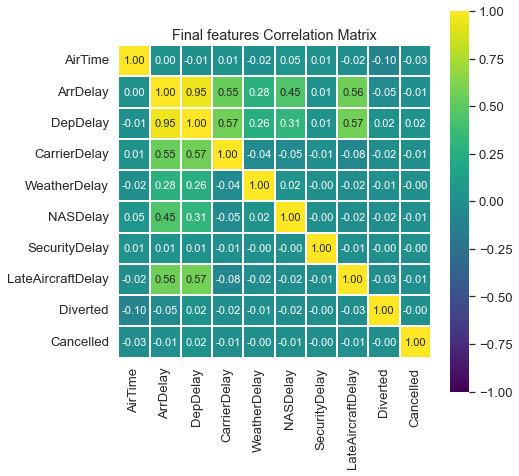

In [4]:
# Check correlation between final selected variables
data_corr = robust_df.corr()

# set style and plot:
sb.set(font_scale=1.2) 
fig, ax = plt.subplots(figsize=(7,7))
ax = sb.heatmap(data = data_corr, 
               square = True,
               annot = True,
               cmap = 'viridis',
               vmin = -1,
               vmax = 1,
               center = 0, 
               linewidths=2,
               ax=ax, 
               annot_kws={"size":11}, fmt='.2f')
            
ax.set(title='Final features Correlation Matrix')
plt.show()
plt.close()


In [5]:
# Split dataset into train and test.
X = robust_df.loc[:, robust_df.columns != 'ArrDelay']
y = robust_df.loc[:, robust_df.columns == 'ArrDelay']
X_train, X_test, y_train, y_test = (train_test_split(X,y, test_size=0.30, random_state=0))
%store X
%store y


Stored 'X' (DataFrame)
Stored 'y' (DataFrame)


## Linear regression model

Intercept: 
 [-0.4584808]
Coefficients: 
 [[-0.01384394  0.04568431  0.20376848  0.02049061  0.12396005  0.02005543
   0.36529703 -0.12147566 -0.15346592]]


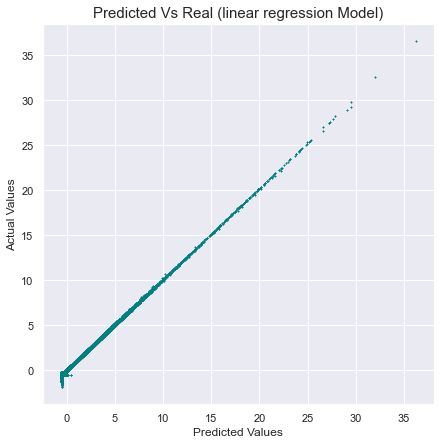

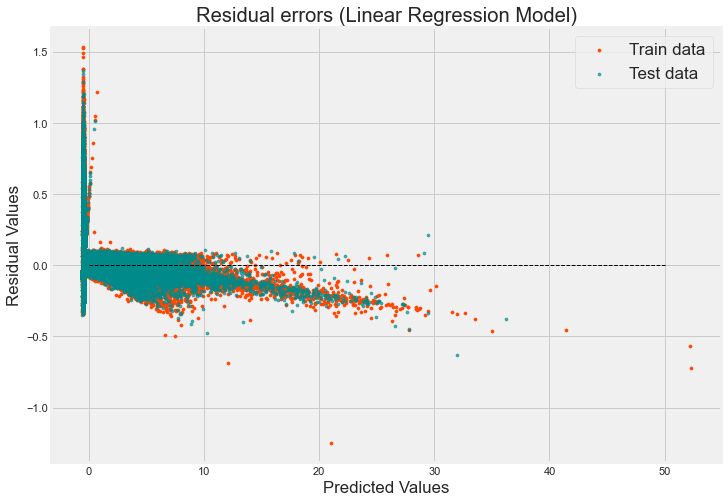

In [6]:
# Create object
regr = linear_model.LinearRegression()

# Train model
regr.fit(X_train, y_train)

# Make predictions
y_predictions = regr.predict(X_test)

# Check model
print("Intercept: \n", regr.intercept_)
print("Coefficients: \n", regr.coef_)

# The mean squared error.
mse_lin = mean_squared_error(y_test, y_predictions)

# The coefficient of determination: 1 is perfect prediction
r2_lin = r2_score(y_test, y_predictions)


# PLot model Accuracy.
sb.set()
plt.figure(figsize=(7,7))
plt.scatter(y_predictions, y_test, marker='x',color='teal', s=1) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Vs Real (linear regression Model)', size=15)
plt.show()
plt.close()

# Plot for residual error
  
## setting plot style
sb.set(style='dark')
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(regr.predict(X_train), regr.predict(X_train) - y_train,
            color = "orangered", s = 10, alpha=1,marker='o', label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(regr.predict(X_test), regr.predict(X_test) - y_test,
            color = 'darkcyan', s = 10, alpha=0.7, marker='o', label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 1, linestyles='dashed', colors='black')
plt.legend(loc = 'best', prop={'size': 17})
plt.title("Residual errors (Linear Regression Model)")
plt.xlabel('Predicted Values')
plt.ylabel('Residual Values')
plt.show()
plt.close()


>Linear model delivers iimpressive results (remember we passed the whole train data, not a sample). The residual errors in both Train and Test data present almost exact shape when plotted


### Random Forest Tree

In [7]:
# Create regressor object
regr = RandomForestRegressor()

# Train model.
regr.fit(X_train, y_train) 

# Make predictions.
y_predictions = regr.predict(X_test)

# Save mean squared error.
mse_rft = mean_squared_error(y_test, y_predictions)

# Save coefficient of determination: 1 is perfect prediction
r2_rft = regr.score(X_test, y_test)


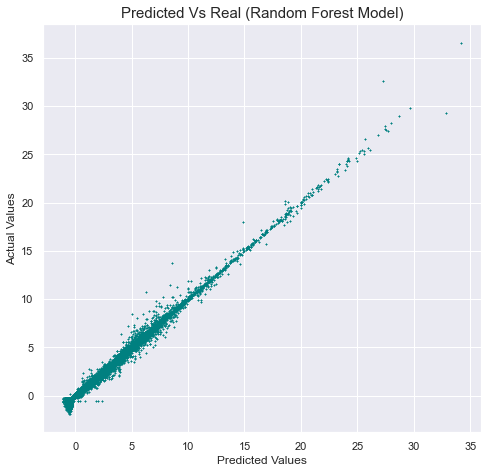

In [8]:
# PLot model Accuracy.
sb.set()
plt.figure(figsize=(7,7))
plt.scatter(y_predictions, y_test, marker='x',color='teal', s=1) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Vs Real (Random Forest Model)', size=15)
plt.show()
plt.close()

## Neural Network model

In [9]:
# Create regressor object.
regr = MLPRegressor()
# Train model.
regr.fit(X_train, y_train)
# Make predictions.
y_predictions = regr.predict(X_test)

# Get mean squared error.
mse_nn = mean_squared_error(y_test, y_predictions)
# Get coefficient of determination: 1 is perfect prediction
r2_nn = regr.score(X_test, y_test)


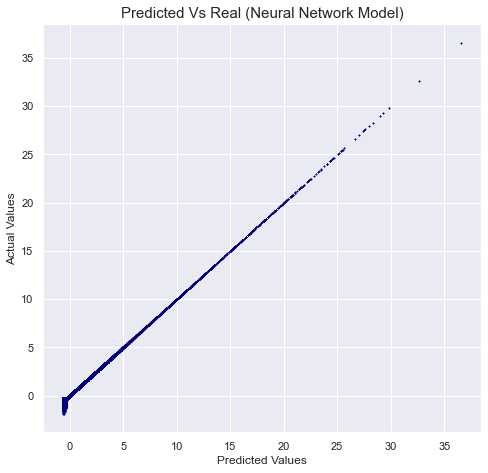

In [10]:
# PLot model Accuracy.
sb.set()
plt.figure(figsize=(7,7))
plt.scatter(y_predictions, y_test, marker='x',color='navy', s=1) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Vs Real (Neural Network Model)', size=15)
plt.show()
plt.close()

## Exercici 2

Compara’ls en base al MSE i al R2 .



In [11]:
# Print results for evaluation
print('Model comparison on Mean Squared Error (MSE)\n')

print(f'MSE for Lineal Regression Model: {mse_lin:.6f}')
print(f'MSE for Random Forest Model: {mse_rft:.6f}')
print(f'MSE for Neural Network Model: {mse_nn:.6f}\n')

print('\nModel comparison on R squared (R2)\n')

print(f"R2 for Lineal Regression Model: {r2_lin:.6f}")
print(f"R2 for Random Forest Model: {r2_rft:.6f}")
print(f"R2 for Neural Network Model: {r2_nn:.6f}")


Model comparison on Mean Squared Error (MSE)

MSE for Lineal Regression Model: 0.010653
MSE for Random Forest Model: 0.010241
MSE for Neural Network Model: 0.008457


Model comparison on R squared (R2)

R2 for Lineal Regression Model: 0.993003
R2 for Random Forest Model: 0.993274
R2 for Neural Network Model: 0.994445


>Although 3 models delivered really good (maybe too-good) values, it's the Neural-Network the one that ends first in both evaluation metrics


## Exercici 3

Entrena’ls utilitzant els diferents paràmetres que admeten.

## Exercici 4

Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)

>As we can check on each of the plots, NNModel outperforms the other ones by a thin margin

## Exercici 5

Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

Nivell 3

>As main feature engineering we could try using logaritmic transformation since most definitely could help with skewed distributions we spotted in the exercise before.
Main problem is we end up losing lots of info on the way, so it's discarded

In [12]:
def check_method(df, x):
    log_df = np.log(df[x])
    log_df = pd.DataFrame(log_df, columns=x)
    
    sb.set()
    fig,(ax1,ax2) = plt.subplots(ncols = 2, figsize =(11, 5))
    fig.suptitle(x, size=20)
    ax1.set_title('Before Logaritmic Transformation')
    sb.boxenplot(data=df[x], ax = ax1, color ='rebeccapurple')
    ax2.set_title('After Logaritmic transformation')
    sb.boxenplot(data=log_df[x], ax = ax2, color ='olive')
    plt.show()
    plt.close()
    return log_df
    


NUmber of Nans before transformation: 0


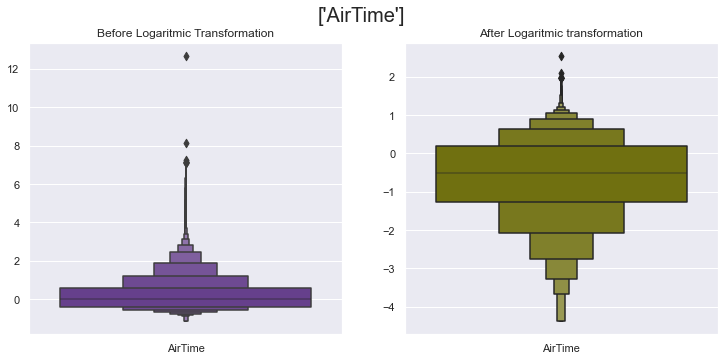

NUmber of Nans after  transformation: AirTime    961911
dtype: int64


In [13]:
print(f'NUmber of Nans before transformation: {robust_df.AirTime.isna().sum()}')
new_AirTime = check_method(robust_df,['AirTime'])
print(f'NUmber of Nans after  transformation: {new_AirTime.isna().sum()}')


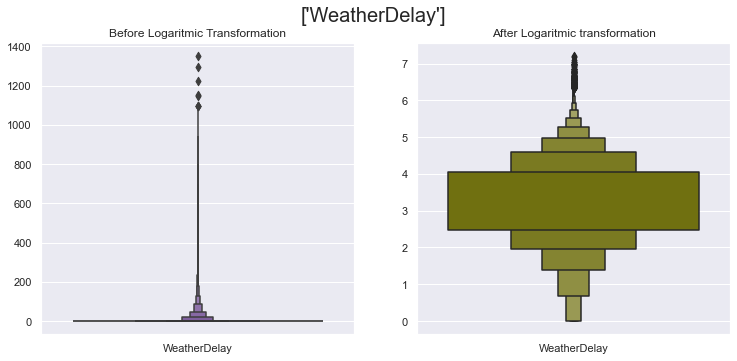

,WeatherDelay
0,-inf
1,-inf
2,-inf
3,-inf
4,-inf
...,...
1936297,-inf
1936298,4.043051
1936299,-inf
1936300,-inf


In [14]:
check_method(robust_df,['WeatherDelay'])

## Exercici 6

No utilitzis la variable DepDelay a l’hora de fer prediccions